# Introduction to atomman: Semidiscrete variational Peierls-Nabarro model

__Lucas M. Hale__, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), _Materials Science and Engineering Division, NIST_.
    
[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 

## 1. Introduction<a id='section1'></a>

This Notebook outlines how to calculate semidiscrete variational Peierls-Nabarro models of dislocation disregistries.  This calculation method gives a prediction for a dislocation structure using only the material's elastic constants and the generalized stacking fault energy map associated with the dislocation's slip plane. 

**NOTE:** the calculation process is complex and may be refined over time resulting in changes to the involved functions and classes.  For this reason, be aware of the atomman version used.

**Library Imports**

In [1]:
# Standard Python libraries
from pathlib import Path
import datetime

# http://www.numpy.org/
import numpy as np

# https://github.com/usnistgov/atomman
import atomman as am
import atomman.unitconvert as uc

# https://matplotlib.org/
import matplotlib.pyplot as plt
%matplotlib inline

# Show atomman version
print('atomman version =', am.__version__)

# Show date of Notebook execution
print('Notebook executed on', datetime.date.today())

atomman version = 1.4.0
Notebook executed on 2021-08-05


## 2. Theory<a id='section2'></a>

The equations and calculations used are based on the original semidiscrete variational Peierls-Nabarro by Bulatov, et. al [[1][1], [2][2], [3][3]], as well as additional and alternate terms [[4][4], [5][5], [6][6], [7][7], [8][8]]. The discussion here is very brief and it is left to the reader to see the referenced papers for more details.
 
### 2.1. Disregistry and dislocation density

The disregistry of a dislocation, $\delta_i$, is defined as the difference in the displacement just above and below the slip plane taken as a function of the coordinate $\xi$ that is along the slip plane and perpendicular to the dislocation line.

$$ \delta_i(\xi) = u_i^+(\xi) - u_i^-(\xi) $$

A dislocation density, $\rho_i$, is also defined that can be thought of as the infinitesimal Burgers vector of the dislocation at any specific $\xi$ point, and is related to $\delta_i$ as

$$ \rho_i(\xi) = \frac{d \delta_i(\xi)}{d \xi} $$

For a slip plane containing a single dislocation in an otherwise infinite medium, $\delta_i$ and $\rho_i$ can be related to the dislocation's Burgers vector, $b_i$

$$ \delta_i(\infty) - \delta_i(-\infty) = b_i $$

$$ \int_{-\infty}^{+\infty}{\rho_i(\xi) d\xi} = b_i $$

### 2.2.  Semidiscrete variational Peierls-Nabarro model

The semidiscrete variational Peierls-Nabarro (SDVPN) model expresses the energy of a dislocation as a summation of different energy terms, each of which is a function of $\delta_i$.  Here, the general dislocation energy equation is

$$ U_{dislocation} = U_{elastic} + U_{misfit} + U_{stress} + U_{surface} + U_{nonlocal} $$

Each of the energy terms is expressed with a discrete formulation that assumes the disregistry is a step function evaluated at certain points and constant in between. The disregistry is evaluated at regular intervals, with $\Delta \xi$ typically corresponding to a spacing of atomic columns along the $\xi$ direction giving the calculation a discreteness corresponding to an actual atomic discreteness.  The SDVPN model then solves for the disregistry at the evaluated $\xi$ points that minimizes the dislocation's energy.

### 2.3. Elastic energy

The elastic energy is due to the elastic energy of the dislocation.  It contains two components: a configuration-dependent part associated with the interaction of the dislocation at one position interacting with the dislocation at another point, and a configuration-independent part associated with the dislocation's long-range strain field. The elastic energy is expressed as

$$ U_{elastic} = \frac{1}{4\pi} \sum_i{\left[ \sum_j{\left( \chi(i, j, \Delta \xi) K_{lm} \rho_l[i] \rho_m[j] \right)} \right]} + \frac{1}{4\pi} K_{lm} b_l b_m \ln{(L)}, $$

where $i$ and $j$ are integer indexes of the $\xi$ evaluation points, i.e. $\xi[i+1] = \xi[i] + \Delta \xi$, $K_{lm}$ is the dislocation's energy coefficient tensor, $L$ is a cutoff radius for the long-range configuration-independent elastic energy, and $\chi$ is a multiplicative factor related to the distance between points $\xi[i]$ and $\xi[j]$ given by

$$ \chi(i,j,\Delta \xi) = \frac{3}{2} \Delta \xi^2 + \psi(i-1,j-1,\Delta \xi) + \psi(i,j,\Delta \xi) - \psi(i,j-1,\Delta \xi) - \psi(j,i-1,\Delta \xi), $$

$$ \psi(i,j,\Delta \xi) = \frac{1}{2} (i-j)^2 \Delta \xi^2 \ln{(|i-j|\Delta \xi)}. $$

The dislocation density, $\rho_l$, is obtained from the discrete $\delta_l$ as

$$ \rho_l[i] = \frac{\delta_l[i] - \delta_l[i-1]}{\Delta \xi} $$

**NOTE:** slightly different forms for $U_{elastic}$ are found in the references due to how the different authors define the energy coefficient tensor, $K_{lm}$.  Here, $K_{lm}$ is defined such that in the isotropic case $K_{33} = K_{screw} = \mu$, and $K_{11} = K_{edge} = \frac{\mu}{1-\nu}$ where $\mu$ is the shear modulus and $\nu$ is the Poisson's ratio.

### 2.4. Misfit energy

The misfit energy arises from the disregistry within the dislocation spreading coinciding with crystallographically unfavorable configurations.  This energy is calculated by mapping the dislocation's disregistry onto a generalized stacking fault energy map, i.e $\gamma$ surface

$$ U_{misfit} = \sum_i \gamma(\delta_l[i]) \Delta \xi. $$

### 2.5. Stress energy

The stress energy computes the energy due to an externally applied stress, $\tau_{ij}$, interacting with the dislocation line.  Two forms have been used in SDVPN models: the original full stress form

$$ U_{stress} = -\frac{1}{2} \sum_i{ \left[ \left(\xi[i]^2 - \xi[i-1]^2 \right) \rho_l[i] \tau_{2l} \right]}, $$

and a truncated form introduced by [[8][8]]

$$ U_{stress} = -\frac{1}{2} \sum_i{ \left[ \tau_{2l} \left(\delta_l[i] + \delta_l[i+1] \right) \Delta \xi  \right]}. $$

The two should be equivalent except for a configuration-independent constant.

### 2.6. Surface energy

The surface energy is a correction term introduced by [[5][5]] to account for the surface effect along the slip plane.  The discrete gradient formulation by [[6][6]] is used by atomman

$$ U_{surface} = \sum_{j=1}^3 {\frac{\beta_{lj}}{4} \sum_i {\rho_l[i]^2 \Delta \xi }}$$

where $\beta_{lj}$ is a coefficient tensor. Terms in the coefficient tensor can be 

### 2.7. Nonlocal energy

The nonlocal energy is an alternate correction term introduced by [[4][4]] to account for the nonlocal interactions directly. It is of the form

$$ U_{nonlocal} = \sum_m{ \alpha_m \sum_i{ \delta_l[i] \left(\delta_l[i] - \frac{\delta_l[i+m] + \delta_l[i-m]}{2} \right) \Delta \xi }} $$

where $\alpha_m$ are correction coefficients corresponding to increasing separations between the evaluated $\xi$ points.  Typically, only the first coefficient $\alpha_1$ is used and it is fitted by minimizing the discrepancy between the SDVPN disregistry and a full atomistic disregistry.


 [1]: https://doi.org/10.1103/PhysRevLett.78.4221
 [2]: https://doi.org/10.1103/PhysRevB.62.3099
 [3]: https://doi.org/10.1080/09500830050143778
 [4]: https://doi.org/10.1016/S0022-5096(98)00057-X
 [5]: https://doi.org/10.1088/1751-8113/42/2/025208
 [6]: https://doi.org/10.1016/j.scriptamat.2016.04.013
 [7]: https://doi.org/10.1016/j.commatsci.2017.01.038
 [8]: https://doi.org/10.1016/j.scriptamat.2009.04.047

## 3. Methodology overview <a id='section3'></a>

Due to the complex nature of the calculation, this section provides a general overview of the steps involved in setting up and running the calculation shown in the remainder of the Notebook.

1. $U_{elastic}$ requires the energy coefficient tensor, $K_{ij}$, which is related to a material's elastic constants and the orientation of the slip plane and elastic constants. 
    a. Isotropic $K_{ij}$ can be calculated using a material's shear modulus and Poisson's ratio: $K_{11} = K_{22} = \frac{\mu}{1-\nu}$, $K_{33} = \mu$, $K_{ij} = 0$ for $i \ne j$.
    b. Anisotropic $K_{ij}$ can be calculated using the Stroh method.
2. A function for $\gamma(\delta_i)$ needs to be created. **NOTE:** Only 2D GSFs currently implemented.
    a. Use an analytical function.
    b. 2D GSF: Measure relaxed generalized stacking fault energies in two dimensions. Interpolate $\gamma(\delta_i)$ dependent on $\delta_1$ and $\delta_3$.
    c. Pseudo 3D GSF: Measure relaxed generalized stacking fault energies in two dimensions and the associated relaxation perpendicular to the fault plane.  Interpolate $\gamma(\delta_i)$ and $\delta_2$ dependent on $\delta_1$ and $\delta_3$.
    d. 3D GSF: Measure unrelaxed generalized stacking fault energies in thre dimensions.  Interpolate $\gamma(\delta_i)$ dependent on $\delta_1$, $\delta_2$ and $\delta_3$.
3. Initial disregistry values need to be given for all of the $\xi$ coordinates.
    a. Use a step function such that $\delta_i(\xi < 0) = 0$ and $\delta_i(\xi > 0) = b_i$
    b. Use an arctan function that smoothly varies from 0 to $b_i$.
4. Solve the SDVPN model with $\tau_{ij}$, $\beta_{ij}$, and $\alpha_m$ values all zero.
5. (Optional) Starting with the SDVPN solution from #4, add either $\beta_{ij}$ or $\alpha_m$ correction constants and solve.
6. (Optional) To obtain a prediction for the dislocation's Peierls barrier, incrementally increase $\tau_{ij}$ and resolve the SDVPN model until the dislocation is observed to move.

## 4. Initialize SDVPN using GammaSurface and VolterraDislocation <a id='section4'></a>

### 4.1. Load $\gamma$ surface results

The atomman.defect.GammaSurface class loads and represents generalized stacking fault data.

See [4.5. Gamma surface plotting Notebook](4.5. Gamma surface plotting.ipynb) for more details on this class.

In [2]:
# Load pre-calculated stacking fault energy data (same data as used in Gamma Surface Plotting Notebook)
model = Path('files', '2008--Mendelev-M-I--Al--A1--Cu--fcc--111sf.json')
gamma = am.defect.GammaSurface(model=model)

box = gamma.box
print('a1vect, a2vect used:')
print(gamma.a1vect)
print(gamma.a2vect)

a1vect, a2vect used:
[ 0.  -0.5  0.5]
[ 0.5 -0.5  0. ]


Plot smallest cell

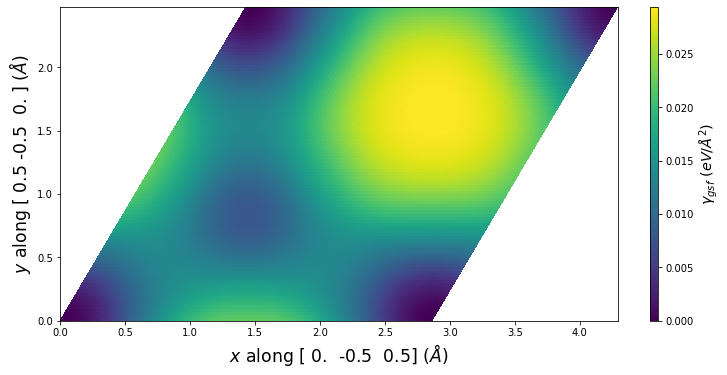

In [3]:
fig = gamma.E_gsf_surface_plot()

Plot common cell representation

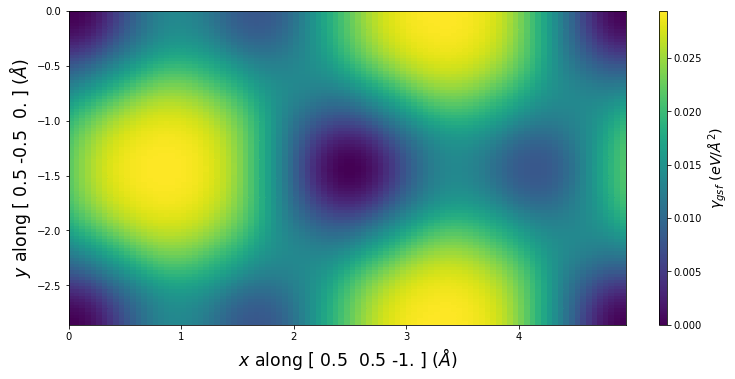

In [4]:
plotting_a1vect = np.array([1, 1, -2]) / 2
plotting_a2vect = np.array([1,-1, 0]) / 2
fig = gamma.E_gsf_surface_plot(a1vect = plotting_a1vect, 
                               a2vect = plotting_a2vect)

### 4.2. Get a Volterra dislocation solution

The model uses Volterra solutions to compute the interaction stresses. A Volterra solution can easily be found using the solve_volterra_dislocation.

See [4.4. Dislocation solution and generator Notebook](4.4. Dislocation solution and generator.ipynb) for more details on the solve_volterra_dislocation function.

__Note__: The slip plane used here must match the slip plane of the gamma surface, otherwise SDVPN will not know how to relate the two!

In [5]:
# Elastic constants for Al using the 2008--Mendelev-M-I--Al potential
C11 = uc.set_in_units(105.09, 'GPa')
C12 = uc.set_in_units( 59.46, 'GPa')
C44 = uc.set_in_units( 30.66, 'GPa')
C = am.ElasticConstants(C11=C11, C12=C12, C44=C44)
print('Cij in GPa:')
print(uc.get_in_units(C.Cij, 'GPa'))

Cij in GPa:
[[105.09  59.46  59.46   0.     0.     0.  ]
 [ 59.46 105.09  59.46   0.     0.     0.  ]
 [ 59.46  59.46 105.09   0.     0.     0.  ]
 [  0.     0.     0.    30.66   0.     0.  ]
 [  0.     0.     0.     0.    30.66   0.  ]
 [  0.     0.     0.     0.     0.    30.66]]


In [6]:
# Miller Burgers vector
burgers_uvw = 0.5 * np.array([1, 0, -1])

# Miller slip plane
slip_hkl = np.array([1, 1, 1])

# The dislocation's line direction (ξ_uvw) determines character
ξ_uvw = [ 1,-2, 1] # 90 degree edge

volterra = am.defect.solve_volterra_dislocation(C, burgers_uvw, ξ_uvw=ξ_uvw, slip_hkl=slip_hkl, box=box)

### 4.3. Initializing an SDVPN object

The Volterra dislocation solution and gamma surface provide all of the materials properties associated with the dislocation problem. During initialization, verification checks will be performed to make certain that the dislocation solution and gamma surface are compatible.

There are many parameters that can be set during initialization.  The first three are the most important, and the remainder are associated with settings listed in the theory section above. All the settings parameters (tau and below) can also be changed later.

Parameters


- **volterra** (*atomman.defect.VolterraDislocation, optional*) The elastic solution for a Volterra dislocation to use as the basis of the model. Either volterra or model are required, and both cannot be given at the same time.
- **gamma** (*atomman.defect.GammaSurface, optional*) The gamma surface to use for the solution.  Required unless model is given and the model content contains gamma surface data.
- **model** (*str or DataModelDict, optional*) Saved data from previous SDVPN runs to load.  Either volterra or model are required, and both cannot be given at the same time.
- **tau** (*numpy.ndarray, optional*) A (3,3) array giving the stress tensor to apply to the system using the stress energy term.  Only the xy, yy, and yz components are used.  Default value is all zeros.
- **alpha** (*list of float, optional*) The alpha coefficient(s) used by the nonlocal energy term.  Default value is [0.0].
- **beta** (*numpy.ndarray, optional*) The (3,3) array of beta coefficient(s) used by the gradient energy term.  Default value is all zeros.
- **cutofflongrange** (*float, optional*) The cutoff distance to use for computing the long-range energy.  Default value is 1000 Angstroms.
- **fullstress** (*bool, optional*) Flag indicating which stress energy algorithm to use.  Default value is True.
- **cdiffelastic** (*bool, optional*) Flag indicating if the dislocation density for the elastic energy component is computed with central difference (True) or simply neighboring values (False).  Default value is False.
- **cdiffsurface** (*bool, optional*) Flag indicating if the dislocation density for the surface energy component is computed with central difference (True) or simply neighboring values (False).  Default value is True.
- **cdiffstress** (*bool, optional*) Flag indicating if the dislocation density for the stress energy component is computed with central difference (True) or simply neighboring values (False).  Only matters if fullstress is True.  Default value is False.
- **min_method** (*str, optional*) The scipy.optimize.minimize method to use.  Default value is 'Powell', which seems to do well for this task.
- **min_options** (*dict, optional*) Any options to pass on to scipy.optimize.minimize. Default value is {}.

**Execution tips:** Tests seem to indicate that the 'Powell' minimization option works well for this problem.  For best results, use min_options to set xtol and ftol to smaller values and run the solver multiple times in a row (minimizer may get stuck).

In [7]:
min_options = {}
min_options['disp'] = True     # will display convergence info
min_options['xtol'] = 1e-6     # smaller convergence tolerance than default
min_options['ftol'] = 1e-6     # smaller convergence tolerance than default
#min_options['maxiter'] = 2    # for testing purposes

# Initialize SDVPN object from volterra and gamma
pnsolution = am.defect.SDVPN(volterra=volterra, gamma=gamma, min_options=min_options)

## 5. Generate initial disregistry  <a id='section5'></a>

Solving the SDVPN model requires starting with an initial guess of the disregistry. 

### 5.1 Initial disregistry

**pn_arctan_disregistry()**

The atomman.defect.pn_arctan_disregistry() function computes the classic Peierls-Nabarro arctan disregistry for an array of points x
        
$$ \delta_i(x) = \frac{b}{\pi} \arctan{ \left( \frac{x}{\xi} \right)} + \frac{b_i}{2} $$

where $\xi$ is the dislocation's halfwidth and $b_i$ is the Burgers vector.

Parameters
    
- **xmax** (*float or None, optional*) Maximum value of x to use.  Minimum value is taken as -xmax.  At least 2 of xmax, xstep, and xnum must be not None.  Default value is None.
- **xstep** (*float or None, optional*) Step size to use between each x value.  At least 2 of xmax, xstep, and xnum must be not None.  Default value is None.
- **xnum** (*int or None, optional*) Number of x values to use.  At least 2 of xmax, xstep, and xnum must be not None.  Default value is None.
- **burgers** (*numpy.ndarray, optional*) The Burgers vector for the dislocation. Default value is [1, 0, 0].
- **halfwidth** (*float, optional*) The dislocation halfwidth to use. Default value is 1.
- **normalize** (*bool, optional*) If True (default), the disregistry values will be scaled such that the two endpoints differ by exactly one Burgers vector.
- **shift** (*bool, optional*) If True (default), the disregistry will range [0, 0, 0] to burgers.  If False, the disregistry will range from -burgers to burgers.
        
Returns

- **x** (*numpy.ndarray*) The x-coordinates for the disregistry values.
- **disregistry** (*numpy.ndarray*) The disregistry vector at each x-coordinate.

**NOTE:** the parameters normalize and shift should both be True for use with the SDVPN model.

Check burgers vector as transformed for the SDVPN solution:

- x = edge component.
- y = normal (out-of-plane) component. Should be 0.0
- z = screw component.

In [8]:
b = pnsolution.burgers
print('Transformed Burgers vector =', b)

Transformed Burgers vector = [2.86043063 0.         0.        ]


Generate arctan disregistry using burgers. 

In [9]:
xstep = box.a * 2**0.5 / 4  # atomic column separation along [10-1] direction
xnum = 100
halfwidth = 2

x, disreg = am.defect.pn_arctan_disregistry(xstep=xstep, xnum=xnum, burgers=b, halfwidth=halfwidth)

Set x, disregistry to the SDVPN object

In [10]:
pnsolution.x = x
pnsolution.disregistry = disreg

### 5.2 Check initial disregistry

The SDVPN class has some built-in methods for checking the disregistry profile and the corresponding energy values.

- __total_energy(), misfit_energy(), elastic_energy(), longrange_energy(), stress_energy(), nonlocal_energy() and surface_energy()__ return the values for the different energy terms based on the current disregistry.
- __check_energies()__ prints out the current energies for all of the different energy terms.
- __disregistry_plot()__ creates a simple plot of the disregistry profiles.
- __E_gsf_surface_plot()__ extends the corresponding GammaSurface method by including a line for the disregistry profile.
- __E_gsf_vs_x_plot()__ plots the stacking fault energy associated with the disregistry values along x versus x.

In [11]:
pnsolution.check_energies()

Dislocation energy terms in eV/Å:
Misfit energy =     0.15241997612247116
Elastic energy =    -0.21141715213384996
Long-range energy = 2.312310391118972
Stress energy =     -0.0
Surface energy =    0.0
Nonlocal energy =   0.0
Total energy =      2.253313215107593


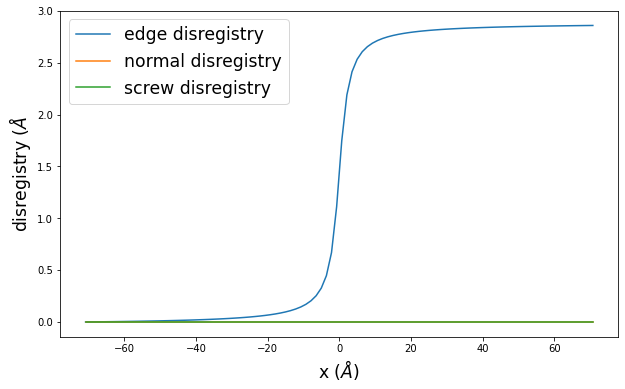

In [12]:
pnsolution.disregistry_plot()
plt.show()

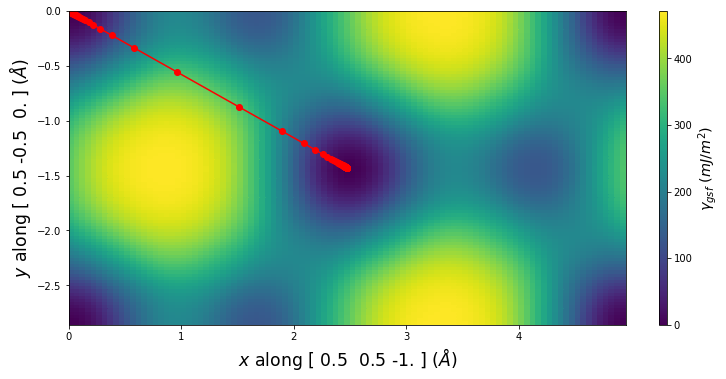

In [13]:
pnsolution.E_gsf_surface_plot(a1vect=plotting_a1vect, a2vect=plotting_a2vect, energyperarea_unit='mJ/m^2')
plt.show()

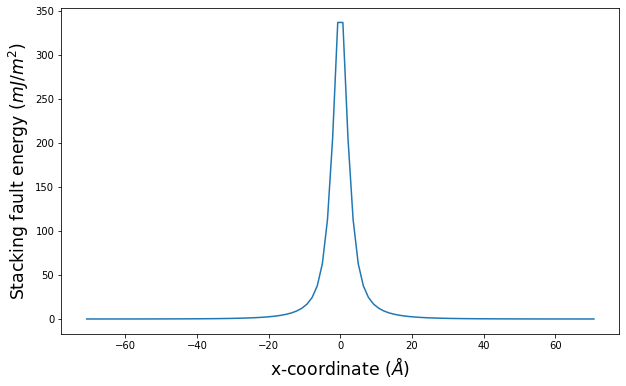

In [14]:
pnsolution.E_gsf_vs_x_plot(energyperarea_unit='mJ/m^2')
plt.show()

## 6. Solve SDVPN model <a id='section6'></a>

Calling the SDVPN.solve() method will perform the energy minimization based on the current values of x, disregistry, and the various settings parameters.  Initial x and disregistry values can be passed to solve() along with new values for the different settings parameters (tau and below for the class initialization parameters).

### 6.1. Call solve the first time

Since x and disregistry have been set using the identified initial values, the minimization will start from there. Also note all options are as specified above. 

In [15]:
pnsolution.solve()

Optimization terminated successfully.
         Current function value: 2.213886
         Iterations: 11
         Function evaluations: 33184


### 6.2. Check results

Dislocation energy terms in eV/Å:
Misfit energy =     0.15773145395826443
Elastic energy =    -0.2561554835193246
Long-range energy = 2.312310391118972
Stress energy =     -0.0
Surface energy =    0.0
Nonlocal energy =   0.0
Total energy =      2.2138863615579116


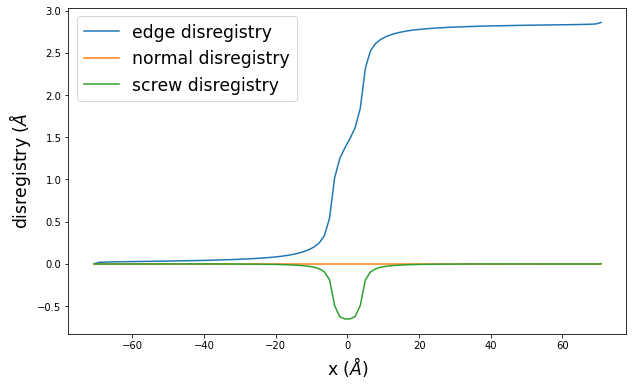

In [16]:
pnsolution.check_energies()
pnsolution.disregistry_plot()
plt.show()

### 6.3. Repeat minimization

The disregistry found after relaxing will replace the initial values in the class.  Subsequent calls to solve() will then use the previous run's final results as the initial starting place.  Doing repeated solves is recommended as it can help further refine the results as the minimization algorithms (especially Powell) benefit from restarts.

Also, note that you can change the various options and settings for subsequent runs.  This can save time if you wish to see relaxed disregistries for multiple different settings, like different stress states, as the two relaxed disregistry states are likely closer to each other than the arbitrary initial state.

In [17]:
for i in range(10):
    pnsolution.solve()

Optimization terminated successfully.
         Current function value: 2.213886
         Iterations: 1
         Function evaluations: 3952
Optimization terminated successfully.
         Current function value: 2.213886
         Iterations: 1
         Function evaluations: 3839
Optimization terminated successfully.
         Current function value: 2.213886
         Iterations: 1
         Function evaluations: 3922
Optimization terminated successfully.
         Current function value: 2.213886
         Iterations: 1
         Function evaluations: 4132
Optimization terminated successfully.
         Current function value: 2.213886
         Iterations: 1
         Function evaluations: 4467
Optimization terminated successfully.
         Current function value: 2.213886
         Iterations: 1
         Function evaluations: 4573
Optimization terminated successfully.
         Current function value: 2.213886
         Iterations: 1
         Function evaluations: 4813
Optimization terminated suc

### 6.4. Check results

Dislocation energy terms in eV/Å:
Misfit energy =     0.15770922556516204
Elastic energy =    -0.25613380502107364
Long-range energy = 2.312310391118972
Stress energy =     -0.0
Surface energy =    0.0
Nonlocal energy =   0.0
Total energy =      2.21388581166306


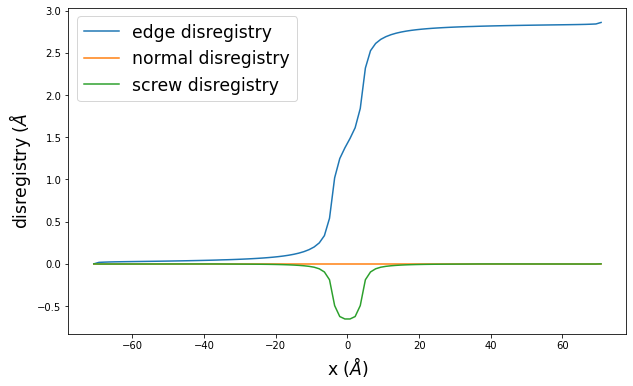

In [18]:
pnsolution.check_energies()
pnsolution.disregistry_plot()
plt.show()

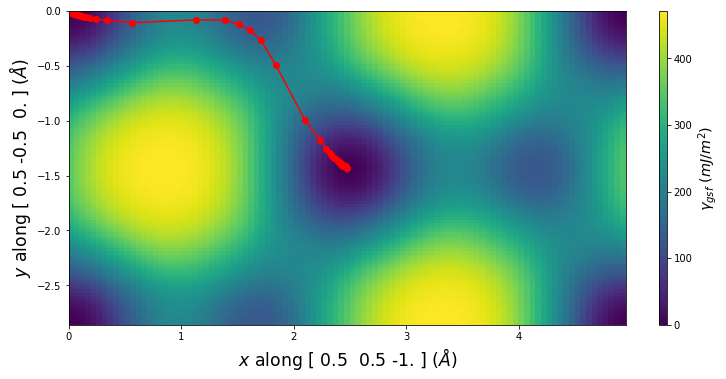

In [19]:
pnsolution.E_gsf_surface_plot(a1vect=plotting_a1vect, a2vect=plotting_a2vect, energyperarea_unit='mJ/m^2')
plt.show()

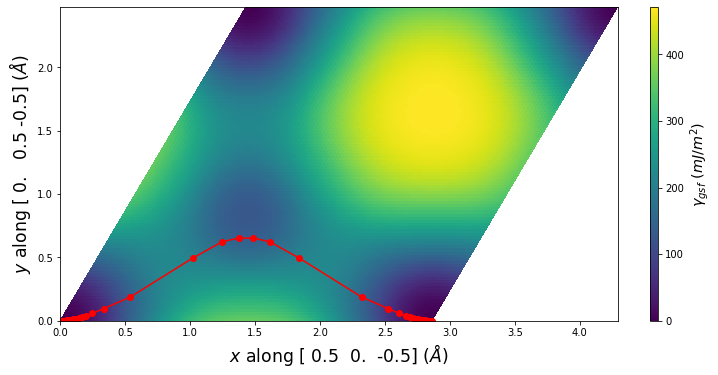

In [20]:
pnsolution.E_gsf_surface_plot(a1vect=[ 0.5, 0., -0.5], a2vect=[0.0,0.5,-0.5], energyperarea_unit='mJ/m^2')
plt.show()

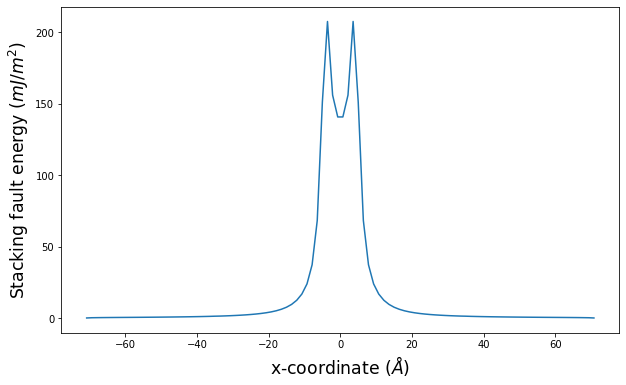

In [21]:
pnsolution.E_gsf_vs_x_plot(energyperarea_unit='mJ/m^2')
plt.show()

## 7. Save and load results

The model() method outputs a data model containing all input settings and the current disregistry vectors.  This can then be saved to JSON or XML and stored for later.  The content can then be read in during SDVPN initialization using the model parameter or using the load() method of an already created SDVPN object.

Parameters

- __length_unit, energyperarea_unit, and pressure_unit__ all control the units the values are saved as.  Will automatically be reinterpreted when loaded.
- __include_gamma__ Flag indicating if the gamma surface data is to be included.  Default value is False.

In [22]:
# Generate model
model = pnsolution.model(include_gamma=True)

# Save as JSON content
with open('sdvpn_run_1.json', 'w', encoding='UTF-8') as f:
    model.json(fp=f, ensure_ascii=False)

Dislocation energy terms in eV/Å:
Misfit energy =     0.15770922556516204
Elastic energy =    -0.25613380502107364
Long-range energy = 2.312310391118972
Stress energy =     -0.0
Surface energy =    0.0
Nonlocal energy =   0.0
Total energy =      2.21388581166306


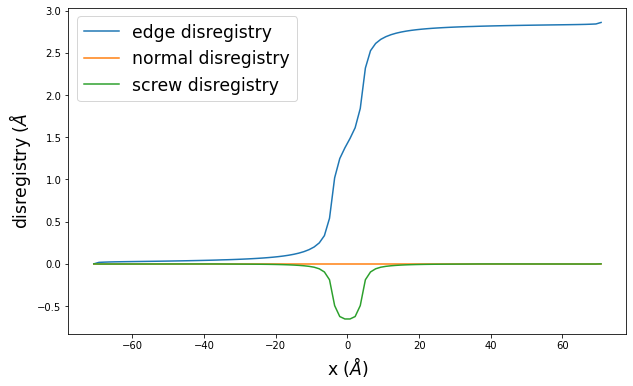

In [23]:
# Load model back in and show that it is in the previous state
pnrestart = am.defect.SDVPN(model='sdvpn_run_1.json')
pnrestart.check_energies()
pnrestart.disregistry_plot()
plt.show()

## 8. Peierls stress estimates

The SDVPN method can provide an extremely rough estimate of the Peierls stress (typically within 10x of atomistic results).  This can be done by 

1. Relaxing the dislocation structure as above.
2. Adjust tau to be incrementally larger along the slip plane.
3. Relax the structure again at the new tau using the relaxed structure from the previous tau as the initial guess.
4. Repeat until the solution fails to converge or the disregistry shows the dislocation line to move a substantial distance.

Work is currently being done to study the sensitivity of this method to the calculation parameters. More details and an example will be provided once results are conclusive.  As of right now, tests seem to indicate the following suggestions:

- xstep needs to correspond to d, the distance between the periodic Peierls valleys along the slip plane in the crystal.  
- The BFGS minimization style seems slightly better at capturing the critical stress than either Powell or CG.
- Results with either stress equation appear to give nearly the same critical stresses.
- There is some variability in the critical stress depending on the sign of tau.  This can in part be due to elastic effects with the fixed x endpoints, but it does not fully account for this.
- Publications claim that including either the surface energy or the nonlocal energy will result in Peierls stress values closer to the direct atomistic values.

**Cleanup**

In [24]:
Path('sdvpn_run_1.json').unlink()